# Library

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install japanize_matplotlib
!pip install optuna
!pip install neologdn
import neologdn
import japanize_matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import LabelEncoder
import datetime as dt
import optuna.integration.lightgbm as lgbm
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import re

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

In [ ]:
# 形態素分析ライブラリーMeCab と 辞書(mecab-ipadic-NEologd)のインストール 
!apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab > /dev/null
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n > /dev/null 2>&1
!pip install mecab-python3 > /dev/null

# シンボリックリンクによるエラー回避
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

import MeCab

fatal: destination path 'mecab-ipadic-neologd' already exists and is not an empty directory.
ln: failed to create symbolic link '/usr/local/etc/mecabrc': File exists


Setting

In [ ]:
input_path = '/content/drive/MyDrive/input/nishika_novelist/'
output_path = '/content/drive/MyDrive/output/nishika_novelist/'
interm_path = '/content/drive/MyDrive/intermediate/nishika_novelist/'
now = dt.datetime.today()
month = str(now.month)
day = str(now.day)
competition_name = 'novelist_prediction'
comment = 'refuct'

save_nm = f'submission_{comment}_{month}_{day}.csv'
print(save_nm)

submission_refuct_11_7.csv


In [ ]:
STUDY_EDA = False
DEBUG = False

keyword_num = 300
title_num = 300
story_num = 300

# Load data

In [ ]:
train_df = pd.read_csv(input_path + 'train.csv')
test_df = pd.read_csv(input_path + 'test.csv')
sample_submission_df = pd.read_csv(input_path + 'sample_submission.csv')
data_explanation_df0 = pd.read_excel(input_path + 'data_explanation.xlsx', sheet_name = 0)
data_explanation_df1 = pd.read_excel(input_path + 'data_explanation.xlsx', sheet_name = 1)

In [ ]:
print(train_df.shape)
train_df.head(3)

(40000, 20)


,ncode,general_firstup,title,story,keyword,userid,writer,biggenre,genre,novel_type,end,isstop,isr15,isbl,isgl,iszankoku,istensei,istenni,pc_or_k,fav_novel_cnt_bin
0,N7588B,2007-04-01 16:40:57,暗い窓辺と皇帝の北の宮,※新しく手直ししました。\n\nhttp://ncode.syosetu.com/n2539l/\n\n宇宙開拓地の入植農家の子供として、小人の「僕」が生まれる。両親は我が子として受け入れよう...,ファンタジー SF 天使 小人 猫,9904,梅田浩志,4,402,1,0,0,0,0,0,0,0,0,0,1
1,N8726B,2007-04-22 15:40:30,仮想現実ゲーム 『ヴァルハラ』,ゲームセンターの片隅に置かれた律儀なまでにリアルなゲーム、ヴァルハラ。それはプレイを重ねるたびに俺たちを魅了していった。そして今日も勇士《エイン》たちの戦いは終わらない。――戦場で育まれる戦友...,仮想現実 ゲーム バトル 戦乙女 高校生 学校/学園 アンドロイド ライト SF エンターテイメント ハイテク 友情 現代(モダン) 未来,6527,ルト,4,401,1,0,0,0,0,0,0,0,0,3,2
2,N5481C,2007-08-22 18:25:54,海の竜騎兵,海軍の中に存在するクジラ部隊「竜騎兵」 主人公はその一員だ。\n騎乗する鯨との間に結ばれた絆は強く、主人公の戦闘能力も次第に洗練されてゆく。\n敵国にライバルが出現。新兵器の登場。\nすばしっ...,ヒーロー 冒険 海軍 深海 海中の戦闘 HJ2021,13882,雨宮雨彦,4,403,1,0,0,0,0,0,0,0,0,0,3


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ncode              40000 non-null  object
 1   general_firstup    40000 non-null  object
 2   title              40000 non-null  object
 3   story              40000 non-null  object
 4   keyword            37774 non-null  object
 5   userid             40000 non-null  int64 
 6   writer             40000 non-null  object
 7   biggenre           40000 non-null  int64 
 8   genre              40000 non-null  int64 
 9   novel_type         40000 non-null  int64 
 10  end                40000 non-null  int64 
 11  isstop             40000 non-null  int64 
 12  isr15              40000 non-null  int64 
 13  isbl               40000 non-null  int64 
 14  isgl               40000 non-null  int64 
 15  iszankoku          40000 non-null  int64 
 16  istensei           40000 non-null  int64

In [ ]:
from sklearn.model_selection import StratifiedKFold
train_target_data = train_df.copy()

train_target_data["target_enc"] = np.nan

folds = StratifiedKFold(n_splits= 5, shuffle=True,random_state=0)
for train_ind, val_ind in folds.split(train_target_data,train_target_data["genre"]):
    # 訓練データと検証データを分ける
    x_train = train_target_data.iloc[train_ind].copy()
    x_val = train_target_data.iloc[val_ind].copy()
    # 訓練データを"月"でgroupbyを行い、"売上個数"の平均を求める。 
    x_train["target_enc"] = x_train.groupby("genre")["fav_novel_cnt_bin"].transform(np.mean)
    # 検証データを使用しないで"月"カラムに対する売上個数の平均を求める
    x_val["target_enc"] = x_val["genre"].map(x_train.groupby("genre")["fav_novel_cnt_bin"].mean())  
    # 検証データの行にtarget_encodingを入れる
    train_target_data.loc[train_target_data.index[val_ind], "target_enc"] = x_val["target_enc"]
train_target_data

,ncode,general_firstup,title,story,keyword,userid,writer,biggenre,genre,novel_type,end,isstop,isr15,isbl,isgl,iszankoku,istensei,istenni,pc_or_k,fav_novel_cnt_bin,target_enc
0,N7588B,2007-04-01 16:40:57,暗い窓辺と皇帝の北の宮,※新しく手直ししました。\n\nhttp://ncode.syosetu.com/n2539l/\n\n宇宙開拓地の入植農家の子供として、小人の「僕」が生まれる。両親は我が子として受け入れよう...,ファンタジー SF 天使 小人 猫,9904,梅田浩志,4,402,1,0,0,0,0,0,0,0,0,0,1,0.815006
1,N8726B,2007-04-22 15:40:30,仮想現実ゲーム 『ヴァルハラ』,ゲームセンターの片隅に置かれた律儀なまでにリアルなゲーム、ヴァルハラ。それはプレイを重ねるたびに俺たちを魅了していった。そして今日も勇士《エイン》たちの戦いは終わらない。――戦場で育まれる戦友...,仮想現実 ゲーム バトル 戦乙女 高校生 学校/学園 アンドロイド ライト SF エンターテイメント ハイテク 友情 現代(モダン) 未来,6527,ルト,4,401,1,0,0,0,0,0,0,0,0,3,2,1.560241
2,N5481C,2007-08-22 18:25:54,海の竜騎兵,海軍の中に存在するクジラ部隊「竜騎兵」 主人公はその一員だ。\n騎乗する鯨との間に結ばれた絆は強く、主人公の戦闘能力も次第に洗練されてゆく。\n敵国にライバルが出現。新兵器の登場。\nすばしっ...,ヒーロー 冒険 海軍 深海 海中の戦闘 HJ2021,13882,雨宮雨彦,4,403,1,0,0,0,0,0,0,0,0,0,3,0.520955
3,N6260C,2007-09-06 21:33:37,宇宙狂時代,はるか未来、宇宙船メーカー「ペガサス」のわずか十八才の社長でもあり、美少女でもあるミリィは、前代未聞の宇宙船によるレースを計画する。ライバル社の「クロノス」に打ち勝つため、なんとみずから宇宙船...,冒険 ロケット ロボット サイボーグ レース コメディ SF エンターテイメント 少女 友情 少年 未来 宇宙,13920,万卜人,4,402,1,0,0,0,0,0,0,0,0,2,1,0.822923
4,N6903C,2007-09-17 01:02:33,クライムズ クライシス,アメリカの大富豪テッドマクシミリアン。心筋梗塞を患った彼があの世に旅立った。弁護士が開いた遺書に書かれていたのはオンラインゲームクライムズを最初にクリアーした者に全財産を与えるというものだった...,ゲーム フェア 平和 権力 ドキドキ シリアス ハッピーエンド 国家/民族 友情 OL/サラリーマン 刑事 現代(モダン),12136,武上 渓,4,401,1,0,0,0,0,0,0,0,0,1,1,1.560241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,N4474HD,2021-08-12 07:00:00,お願い採りすぎないで！！,聖属性エッセイストの日常妄想系エッセイですよ〜! 今回は、ちょっとだけ毒を吐きます。\n\nお暇なら読んでね～!,サワガニ 乱獲 根こそぎ ネットで晒す 穴場 セミ 採りすぎないで マナー,1964264,ひだまりのねこ,99,9903,2,0,0,0,0,0,0,0,0,2,2,0.575194
39996,N4539HD,2021-08-12 07:36:14,人生最初で最後の1年間の高校生生活。,生まれてから僕は病院から出たことが無い。\nそんな僕が学校に憧れる。\n\nもう何度目かも分からない数の交渉の末に\n【1年間のみ】\nという条件で両親に高校に通わせて貰った。\n\nそんな特...,スクールラブ 日常 青春 私小説 ラブコメ シリアス 男主人公 ほのぼの 学園 短編 現実世界【恋愛】 ESN大賞３ OVL大賞7 新人発掘コンテスト,2180545,白雪,1,102,2,0,0,0,0,0,0,0,0,2,0,1.041270
39997,N4540HD,2021-08-12 07:44:36,火星のオリンピック,23世紀の火星でオリンピックが開催されている。招待客である地球の国連事務次官ボルト氏と火星植民地のピサロ総督が和やかにゲームを観戦しているが、競技場に集う選手たちの風貌は想像を絶するものであった。,近未来 火星 植民地 地球 ピサロ オリンピック 100メートル決勝,2212561,オモト ラム,3,307,2,0,0,0,0,0,0,0,0,2,0,0.627742
39998,N4496HD,2021-08-12 08:00:00,魔物図鑑の人,討伐依頼を受ける冒険者に渡される一冊の本\n\n本の名前は「魔物図鑑」\n\nそこには魔物のありとあらゆる情報が載っていた――\n\n,魔法 ギルド 主人公最強 魔物,535814,ながワサビ64,2,201,2,0,0,0,0,0,0,0,0,2,2,1.561187


In [ ]:
test_target_data = test_df.copy()
target = train_target_data.groupby("genre").agg({"target_enc": np.mean}).reset_index()
test_target_data = pd.merge(test_target_data, target, on="genre")
test_target_data

,ncode,general_firstup,title,story,keyword,userid,writer,biggenre,genre,novel_type,end,isstop,isr15,isbl,isgl,iszankoku,istensei,istenni,pc_or_k,target_enc
0,N4541HD,2021-08-12 08:00:00,５年生の男の子がマスクを着用したまま持久走をして亡くなりました！ 今年2月のお話しです,私の連載しているエッセイ「新型コロナウィルスについて」より抜粋しています。\n\n令和3年5月30日に掲載したものです。,新型コロナウイルス 新型コロナウィルス COVID-19 コロナ脳 コロナ マスク ウイルス 必要 無意味 非科学的 科学的根拠 インフォデミック マスク警察 経済 宗教,952106,天乃川シン,99,9903,2,0,0,0,0,0,0,0,0,2,0.582776
1,N4550HD,2021-08-12 08:20:48,運命,「運命」というものについて思うことを書きました。,R15 運命,1164424,司 征,99,9903,2,0,0,1,0,0,0,0,0,2,0.582776
2,N4563HD,2021-08-12 08:41:30,漫画『1518! イチゴーイチハチ!』を読み返して気付いたある恐ろしさ。,先日、本棚の整理をしていたときに見つけた相田裕氏の「1518! イチゴーイチハチ!」を読んでいて、思い出したことがありました。気になる表現があって、雑誌連載時にも調べたことがあったのですが、...,1518! 伊佐沼 日本の湖沼 関東２位 wiki Wikipedia ウィキペディア ネット情報 信頼性 垂れ流し 鵜呑み 危険,1204972,鶴舞麟太郎,99,9903,2,0,0,0,0,0,0,0,0,2,0.582776
3,N4575HD,2021-08-12 09:31:55,文学仲間Jに宛てた書簡,剣と魔法の物語を書くにはプレートテクトニクスから考証を始めないとダメだ！とつまずいていた私が自分なりに折り合いをつけて小説を書けるようになった話,私小説,1149061,石田 初羽,99,9903,2,0,0,0,0,0,0,0,0,2,0.582776
4,N4578HD,2021-08-12 10:00:00,引きこもりの気持ちがよく分かる。,久しぶりの短編小説です。また一からがんばっていきます,NaN,2195992,とんかつ醤油,99,9903,2,0,0,0,0,0,0,0,0,2,0.582776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8517,N7456HE,2021-09-06 11:15:05,とあるネット記事に感じたこと,ネット上で根拠のないフェイク記事を見たことに関しての駄文ですm(_ _)m,NaN,1804184,愛猫家 奴隷乙,99,9904,2,0,0,0,0,0,0,0,0,2,0.784482
8518,N0919HF,2021-09-13 19:29:12,同棲中の彼女を起こすのは「戦い」と言って差し支えない,寝相悪い彼女を起こします。,R15 公式シナリオ使用 SW2.0 オフィスラブ 日常 ラブコメ,2077080,宮田,99,9904,2,0,0,1,0,0,0,0,0,2,0.784482
8519,N0988HF,2021-09-13 21:28:42,GBA FINAL FANTASY 4 アドバンス,GBAのレトロゲームをやってみた感想文です。,残酷な描写あり GBA レトロゲーム FF4 レビュー,1464426,パタゴニア・ロウ,99,9904,2,0,0,0,0,0,1,0,0,2,0.784482
8520,N1331HF,2021-09-14 18:07:52,続き 山田禍夏牟 間違い 末因笠児 でした 正しい 末因のほう 前作,補足\n追加\n\n山田禍夏牟 まちがい\n\n末因笠児のほう\n\n前作 続き そのまま 設定だけと\n\n別\n,R15 主人公が蛇柄 蛇柄主人公 蛇柄の主人公 続き 補足 追加 別 仲間 異空間 ルール 模倣住人 怪人 生き残り,1796581,呪怨 闇音,99,9904,2,0,0,1,0,0,0,0,0,2,0.784482


In [ ]:
# train_df['train_test'] = 'train'
# test_df['train_test'] = 'test'
# train_test = pd.concat([train_df, test_df], axis = 0).reset_index(drop = True)

In [ ]:
train_target_data['train_test'] = 'train'
test_target_data['train_test'] = 'test'
train_test = pd.concat([train_target_data, test_target_data], axis = 0).reset_index(drop = True)

In [ ]:
train_test.head(3)

,ncode,general_firstup,title,story,keyword,userid,writer,biggenre,genre,novel_type,end,isstop,isr15,isbl,isgl,iszankoku,istensei,istenni,pc_or_k,fav_novel_cnt_bin,target_enc,train_test
0,N7588B,2007-04-01 16:40:57,暗い窓辺と皇帝の北の宮,※新しく手直ししました。\n\nhttp://ncode.syosetu.com/n2539l/\n\n宇宙開拓地の入植農家の子供として、小人の「僕」が生まれる。両親は我が子として受け入れよう...,ファンタジー SF 天使 小人 猫,9904,梅田浩志,4,402,1,0,0,0,0,0,0,0,0,0,1.0,0.815006,train
1,N8726B,2007-04-22 15:40:30,仮想現実ゲーム 『ヴァルハラ』,ゲームセンターの片隅に置かれた律儀なまでにリアルなゲーム、ヴァルハラ。それはプレイを重ねるたびに俺たちを魅了していった。そして今日も勇士《エイン》たちの戦いは終わらない。――戦場で育まれる戦友...,仮想現実 ゲーム バトル 戦乙女 高校生 学校/学園 アンドロイド ライト SF エンターテイメント ハイテク 友情 現代(モダン) 未来,6527,ルト,4,401,1,0,0,0,0,0,0,0,0,3,2.0,1.560241,train
2,N5481C,2007-08-22 18:25:54,海の竜騎兵,海軍の中に存在するクジラ部隊「竜騎兵」 主人公はその一員だ。\n騎乗する鯨との間に結ばれた絆は強く、主人公の戦闘能力も次第に洗練されてゆく。\n敵国にライバルが出現。新兵器の登場。\nすばしっ...,ヒーロー 冒険 海軍 深海 海中の戦闘 HJ2021,13882,雨宮雨彦,4,403,1,0,0,0,0,0,0,0,0,0,3.0,0.520955,train


# EDA

In [ ]:
if STUDY_EDA:
    display(data_explanation_df0.head())
    display(data_explanation_df1.head(30))

In [ ]:
if STUDY_EDA:
    for col_nm in train_test.columns:
        
        print(col_nm)
        print(train_test[col_nm].nunique())
        print(train_test[col_nm].unique())
        print('*'*100)
        print('*'*100)
        print('*'*100)

In [ ]:
rem_symbol_list = [
    '!',
    '"',
    '#',
    '$',
    '%',
    '&',
    '(',
    ')',
    '-',
    '=',
    '^',
    '~',
    '|',
    '@',
    '[',
    '{',
    '`',
    ';',
    '+',
    ':',
    '*',
    ']',
    '}',
    ',',
    '<',
    '.',
    '>',
    '/',
    '?',
    '_',
    '「',
    '」',
    '。',
    '、'               
]

rem_num_list = [chr(i) for i in range(48, 48+10)]
rem_num_list += [chr(i) for i in range(65296, 65296+10)]

rem_moji_list = [chr(i) for i in range(12353, 12436)]
rem_moji_list += [chr(i) for i in range(12449, 12532+1)]
rem_moji_list += [chr(i) for i in range(97, 97+26)]
rem_moji_list += [chr(i) for i in range(65, 65+26)]

rem_dob_symbol_list = [str(ii) + str(jj) for ii in rem_symbol_list for jj in rem_symbol_list]

rem_word_list = rem_symbol_list + rem_dob_symbol_list + rem_num_list + rem_moji_list

In [ ]:
# !pip install urllib
import urllib.request
slothlib_path = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
slothlib_file = urllib.request.urlopen(slothlib_path)
slothlib_stopwords = [line.decode("utf-8").strip() for line in slothlib_file]
slothlib_stopwords = [ss for ss in slothlib_stopwords if not ss==u'']

In [ ]:
rem_stopwords_list = rem_word_list + slothlib_stopwords

#Preprossing

## general_firstup

In [ ]:
train_test['general_firstup'] = pd.to_datetime(train_test['general_firstup'], format='%Y-%m-%d').dt.date
print(train_test['general_firstup'].max())
print(train_test['general_firstup'].min())

2021-09-23
2007-04-01


In [ ]:
train_test['date_fromup'] = train_test['general_firstup'].max() - train_test['general_firstup']
train_test['date_fromup'] = train_test['date_fromup'].dt.days

## userid, writer

In [ ]:
writer_df = train_test[['userid', 'writer']].drop_duplicates()
writernum_df = pd.DataFrame(writer_df['userid'].value_counts())
writernum_df = writernum_df.rename(columns = {'userid':'userid_double_count'})
writernum_df['userid'] = writernum_df.index
writernum_df = writernum_df.reset_index(drop = True)
writernum_df.head()

,userid_double_count,userid
0,88,1275419
1,24,815315
2,21,1098859
3,9,663566
4,8,502617


In [ ]:
print(train_test.shape)

train_test = pd.merge(
    train_test,
    writernum_df,
    on = 'userid',
    how = 'left'
)

print(train_test.shape)

(48522, 23)
(48522, 24)


In [ ]:
train_test['userid_count'] = train_test.groupby('userid')['userid'].transform('count')
train_test['writer_count'] = train_test.groupby('writer')['writer'].transform('count')

## normalize word

## keyword, title, **story**

In [ ]:
train_test['story'] = train_test['story'].apply(lambda x:neologdn.normalize(x))

train_test['story'] = train_test['story'].apply(lambda x :re.sub(
    r'(http|https)://([-\w]+\.)+[-\w]+(/[-\w./?%&=]*)?', 
    "", 
    x
))

train_test['story'] = train_test['story'].apply(lambda x:x.replace('\n', ''))


train_test['title'] = train_test['title'].apply(lambda x:neologdn.normalize(x))
train_test['title'] = train_test['title'].apply(lambda x :re.sub(
    r'(http|https)://([-\w]+\.)+[-\w]+(/[-\w./?%&=]*)?', 
    "", 
    x
))

train_test['title'] = train_test['title'].apply(lambda x:x.replace('\n', ''))

In [ ]:
train_test['length_title'] = train_test['title'].apply(lambda x:len(x))
train_test['length_story'] = train_test['story'].apply(lambda x:len(x))
train_test['length_keyword'] = train_test['keyword'].astype(str).apply(lambda x:len(x))

### keyword

In [ ]:
# 人気度的なデータを生成
train_test['keyword'] = train_test['keyword'].astype(str)
keyword_list = set()
keyword_dict = dict()

for i in range(len(train_test)): 
    print("\r"+str(i),end="")
    for keyword in train_test['keyword'].iloc[i].replace('\u3000', ' ').split(' '):
        
        if (keyword != '') & (keyword not in rem_stopwords_list) :
            keyword_list.add(str(keyword))
            
            try:
                keyword_dict[keyword] += 1
            except:
                keyword_dict[keyword] = 0


48521

In [ ]:
for k, v in list(keyword_dict.items()):
    if v <= keyword_num:
      keyword_dict.pop(k, None)
      keyword_list.remove(k)

In [ ]:
print(train_test.shape)

# カラムを作成。初期値0
for keyword in keyword_list:
    train_test[keyword] = 0

print(train_test.shape)

(48522, 29)
(48522, 151)


In [ ]:
# 人気度的なデータを生成
for i in range(len(train_test)):
    print("\r"+str(i),end="")
    for keyword in train_test['keyword'].iloc[i].replace('\u3000', ' ').split(' '):
        
        if (keyword != '') & (keyword in train_test.columns):
            train_test[keyword].iloc[i] = keyword_dict[keyword]

24

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



48521

In [ ]:
# 人気度合計カラムを生成
train_test['keyword_sum'] = 0
for keyword in keyword_list:
    train_test['keyword_sum'] += train_test[keyword]

### title

In [ ]:
tagger = MeCab.Tagger('-Ochasen')

print(train_test.shape)

noun_title_dict = dict()
noun_title_list = set()

for i in range(len(train_test)): 
    print("\r"+str(i),end="")
    title_text = train_test['title'].iloc[i]

    nouns = [line.split()[0] for line in tagger.parse(title_text).splitlines()
               if "名詞" in line.split()[-1]]

    for noun in nouns:
        
        if noun not in rem_stopwords_list:

            noun_title_list.add(noun + '_title')

            if noun + '_title' in noun_title_dict.keys():
                noun_title_dict[noun + '_title'] += 1
            else:
                noun_title_dict[noun + '_title'] = 0

for k, v in list(noun_title_dict.items()):
    if v <= title_num:
      noun_title_dict.pop(k, None)
      noun_title_list.remove(k)

# カラムを作成。初期値0
for noun_title in noun_title_list:
    train_test[noun_title] = 0

print(train_test.shape)

(48522, 152)
48521(48522, 189)


In [ ]:
# 人気度的なデータを生成
for i in range(len(train_test)):
    print("\r"+str(i),end="")
    title_text = train_test['title'].iloc[i]

    nouns = [line.split()[0] for line in tagger.parse(title_text).splitlines()
               if "名詞" in line.split()[-1]]

    for noun in nouns:
        if noun + '_title' in train_test.columns:
            train_test[noun + '_title'].iloc[i] = noun_title_dict[noun + '_title']

# 人気度合計カラムを生成
train_test['title_sum'] = 0
for noun_title in noun_title_list:
    train_test['title_sum'] += train_test[noun_title]

110

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



48521

### story

In [ ]:
tagger = MeCab.Tagger('-Ochasen')

print(train_test.shape)

noun_story_dict = dict()
noun_story_list = set()

for i in range(len(train_test)): 
    print("\r"+str(i),end="")
    story_text = train_test['story'].iloc[i]

    nouns = [line.split()[0] for line in tagger.parse(story_text).splitlines()
               if "名詞" in line.split()[-1]]

    for noun in nouns:

        if noun not in rem_stopwords_list:    

            noun_story_list.add(noun + '_story')

            if noun + '_story' in noun_story_dict.keys():
                noun_story_dict[noun + '_story'] += 1
            else:
                noun_story_dict[noun + '_story'] = 0

for k, v in list(noun_story_dict.items()):
    if v <= story_num:
      noun_story_dict.pop(k, None)
      noun_story_list.remove(k)

# カラムを作成。初期値0
for noun_story in noun_story_list:
    train_test[noun_story] = 0

print(train_test.shape)

(48522, 190)
48521(48522, 688)


In [ ]:
# 人気度的なデータを生成
for i in range(len(train_test)):
    print("\r"+str(i),end="")
    story_text = train_test['story'].iloc[i]

    nouns = [line.split()[0] for line in tagger.parse(story_text).splitlines()
               if "名詞" in line.split()[-1]]

    for noun in nouns:
        if noun + '_story' in train_test.columns:
            train_test[noun + '_story'].iloc[i] = noun_story_dict[noun + '_story']

# 人気度合計カラムを生成
train_test['story_sum'] = 0
for noun_story in noun_story_list:
    train_test['story_sum'] += train_test[noun_story]

16

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



48521

### target_feature

In [ ]:
train_test['target_length_keyword'] = train_test['target_enc'] * train_test['length_keyword']
train_test['target_length_title'] = train_test['target_enc'] * train_test['length_title']
train_test['target_length_story'] = train_test['target_enc'] * train_test['length_story']

train_test['target_keyword_sum'] = train_test['target_enc'] * train_test['keyword_sum']
train_test['target_title_sum'] = train_test['target_enc'] * train_test['title_sum']
train_test['target_story_sum'] = train_test['target_enc'] * train_test['story_sum']

train_test['target_userid_count'] = train_test['target_enc'] * train_test['userid_count']
train_test['target_writer_count'] = train_test['target_enc'] * train_test['writer_count']

## label_encode

In [ ]:
label_cols = ['userid', 'writer']

le = LabelEncoder()

for label_col in label_cols:
    le = LabelEncoder()
    train_test[label_col] = le.fit_transform(train_test[label_col])

In [ ]:
train_test.head(3)

,ncode,general_firstup,title,story,keyword,userid,writer,biggenre,genre,novel_type,end,isstop,isr15,isbl,isgl,iszankoku,istensei,istenni,pc_or_k,fav_novel_cnt_bin,target_enc,train_test,date_fromup,userid_double_count,userid_count,writer_count,length_title,length_story,length_keyword,ミリタリー,伝奇,少女,宇宙,ボーイズラブ,主人公最強,時代小説,友情,悲恋,身分差,OVL大賞7M,学園,女主人公,群像劇,幼馴染,スプラッタ,職業もの,ほのぼの,ラブコメ,ミステリー,史実,...,魂_story,魔法_story,闇_story,魔力_story,誤字_story,自殺_story,友人_story,譚_story,生徒_story,情報_story,ショート_story,女性_story,場所_story,ランキング_story,展開_story,興味_story,空_story,運命_story,さま_story,剣_story,光_story,解決_story,船_story,ホラー_story,ラブ_story,空間_story,犯人_story,主_story,主催_story,ノベル_story,ギルド_story,中学_story,気持ち_story,卒業_story,位_story,討伐_story,ミステリー_story,応募_story,最_story,有名_story,親友_story,story_sum,target_length_keyword,target_length_title,target_length_story,target_keyword_sum,target_title_sum,target_story_sum,target_userid_count,target_writer_count
0,N7588B,2007-04-01,暗い窓辺と皇帝の北の宮,※新しく手直ししました。宇宙開拓地の入植農家の子供として、小人の「僕」が生まれる。両親は我が子として受け入れようとし、飼い猫のロマノフも「僕」の世話をしてくれる。しかし、子供達は受け入れてはく...,ファンタジー SF 天使 小人 猫,44,13724,4,402,1,0,0,0,0,0,0,0,0,0,1.0,0.815006,train,5289,1,3,3,11,211,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13168,13.855097,8.965063,171.966208,2454.797251,0.000000,10731.995418,2.445017,2.445017
1,N8726B,2007-04-22,仮想現実ゲーム『ヴァルハラ』,ゲームセンターの片隅に置かれた律儀なまでにリアルなゲーム、ヴァルハラ。それはプレイを重ねるたびに俺たちを魅了していった。そして今日も勇士《エイン》たちの戦いは終わらない。ー戦場で育まれる戦友達...,仮想現実 ゲーム バトル 戦乙女 高校生 学校/学園 アンドロイド ライト SF エンターテイメント ハイテク 友情 現代(モダン) 未来,27,7714,4,401,1,0,0,0,0,0,0,0,0,3,2.0,1.560241,train,5268,1,2,3,14,112,69,0,0,0,0,0,0,0,305,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13739,107.656627,21.843373,174.746988,8626.572289,741.114458,21436.150602,3.120482,4.680723
2,N5481C,2007-08-22,海の竜騎兵,海軍の中に存在するクジラ部隊「竜騎兵」主人公はその一員だ。騎乗する鯨との間に結ばれた絆は強く、主人公の戦闘能力も次第に洗練されてゆく。敵国にライバルが出現。新兵器の登場。すばしっこく泳ぐ鯨に魚...,ヒーロー 冒険 海軍 深海 海中の戦闘 HJ2021,68,19098,4,403,1,0,0,0,0,0,0,0,0,0,3.0,0.520955,train,5146,1,9,9,5,121,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9001,13.544828,2.604775,63.035544,2220.309814,0.000000,4689.115119,4.688594,4.688594


# Model

In [ ]:
train_test.columns.tolist()

['ncode',
 'general_firstup',
 'title',
 'story',
 'keyword',
 'userid',
 'writer',
 'biggenre',
 'genre',
 'novel_type',
 'end',
 'isstop',
 'isr15',
 'isbl',
 'isgl',
 'iszankoku',
 'istensei',
 'istenni',
 'pc_or_k',
 'fav_novel_cnt_bin',
 'target_enc',
 'train_test',
 'date_fromup',
 'userid_double_count',
 'userid_count',
 'writer_count',
 'length_title',
 'length_story',
 'length_keyword',
 'ミリタリー',
 '伝奇',
 '少女',
 '宇宙',
 'ボーイズラブ',
 '主人公最強',
 '時代小説',
 '友情',
 '悲恋',
 '身分差',
 'OVL大賞7M',
 '学園',
 '女主人公',
 '群像劇',
 '幼馴染',
 'スプラッタ',
 '職業もの',
 'ほのぼの',
 'ラブコメ',
 'ミステリー',
 '史実',
 '私小説',
 '溺愛',
 '123大賞',
 '異世界転生',
 'ホラー',
 'ダンジョン',
 'スペースオペラ',
 'IF戦記',
 'パラレルワールド',
 'バイオハザード',
 '年の差',
 'アニメイト耳聴き1',
 'ヒストリカル',
 'キネノベ大賞３',
 '人工知能',
 '戦争',
 '近未来',
 'ガールズラブ',
 '異能力バトル',
 'アンドロイド',
 'SF',
 '天災',
 '美少女',
 '悪役令嬢',
 'エイリアン',
 '勇者',
 '現代',
 'シリアス',
 'サイコホラー',
 '怪獣',
 '転生',
 '残酷な描写あり',
 'ファンタジー',
 'ヒーロー',
 '新人発掘コンテスト',
 '中世',
 '人外',
 '乙女ゲーム',
 'R15',
 '怪談',
 '男主人公',
 'ゲーム',
 'サスペンス',
 '異世界転移',
 'ディストピア

In [ ]:
drop_cols = [
    'ncode',
    'general_firstup',
    'title',
    'story',
    'keyword'
 ]

In [ ]:
train_test = train_test.drop(columns = drop_cols)
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48522 entries, 0 to 48521
Columns: 692 entries, userid to target_writer_count
dtypes: float64(10), int64(681), object(1)
memory usage: 256.5+ MB


In [ ]:
target = 'fav_novel_cnt_bin'

preprocessed_train_df = train_test[train_test['train_test'] == 'train'].drop(columns = 'train_test')
preprocessed_test_df = train_test[train_test['train_test'] == 'test'].drop(columns = ['train_test', target])

if DEBUG == True:
    x = preprocessed_train_df.drop(columns = target)[:500]
    y = preprocessed_train_df[target][:500]

else:
    x = preprocessed_train_df.drop(columns = target)
    y = preprocessed_train_df[target]

In [ ]:
# foldデータ作成
fold = KFold(n_splits=5, shuffle=True, random_state=42)
# fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv = list(fold.split(x, y))

def fit_lgbm(x, y, cv, params: dict=None, verbose=100):
        
    oofs_lgbm = []
    models_lgbm = []
    scores_lgbm = []
    
    for i, (idx_train, idx_valid) in enumerate(cv): 
        
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = x[idx_train], y[idx_train]
        x_valid, y_valid = x[idx_valid], y[idx_valid]
        
        oof_pred = np.zeros(len(y_valid), dtype=np.float32)
        
        trains = lgbm.Dataset(x_train, y_train)
        valids = lgbm.Dataset(x_valid, y_valid)

        model = lgbm.train(
            params, 
            trains,
            valid_sets = valids,
            num_boost_round = 50000,
            verbose_eval = False,
            early_stopping_rounds = 100
        )

        
        oof_pred = model.predict(x_valid)
        # score = log_loss(oof_pred, y_valid)

        print('*'*50)
        print('*'*50)
        print('*'*50)
        
        print(f'fold{i+1}finished')
        print(model.params)
        # print('rmse:', score)
        
        print('*'*50)
        print('*'*50)
        print('*'*50)
        
        oofs_lgbm.append(oof_pred)
        models_lgbm.append(model)
        
        # scores_lgbm.append(score)
        
    return oofs_lgbm, models_lgbm
    # , scores_lgbm

params = {
    'objective':'multiclass',
    'num_class': 5,
    'metric':'multi_logloss'
}

oofs_lgbm, models_lgbm = fit_lgbm(
    x.values, 
    y,
    cv,
    params
)

In [ ]:
import lightgbm as lgbm

def fit_lgbm(x, y, cv, params: dict=None, verbose=100):
        
    oofs_lgbm = []
    models_lgbm = []
    scores_lgbm = []
    
    for i, (idx_train, idx_valid) in enumerate(cv): 
        
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = x[idx_train], y[idx_train]
        x_valid, y_valid = x[idx_valid], y[idx_valid]
        
        oof_pred = np.zeros(len(y_valid), dtype=np.float32)
        
        trains = lgbm.Dataset(x_train, y_train)
        valids = lgbm.Dataset(x_valid, y_valid)

        model = lgbm.train(
            params, 
            trains,
            valid_sets = valids,
            num_boost_round = 50000,
            verbose_eval = 100,
            early_stopping_rounds = 100
        )

        
        oof_pred = model.predict(x_valid)
        # score = log_loss(oof_pred, y_valid)

        print('*'*50)
        print('*'*50)
        print('*'*50)
        
        print(f'fold{i+1}finished')
        # print('rmse:', score)
        
        print('*'*50)
        print('*'*50)
        print('*'*50)
        
        oofs_lgbm.append(oof_pred)
        models_lgbm.append(model)
        # scores_lgbm.append(score)
        
    return oofs_lgbm, models_lgbm
    # , scores_lgbm

SEED = 0

params = {
    'objective': 'multiclass',
    'num_classes': 5,
    'metric': 'multi_logloss',
    'num_leaves': 60,
    # 'max_depth': 7,
    "feature_fraction": 0.2,
    'subsample_freq': 1,
    "bagging_fraction": 1.0,
    'min_data_in_leaf': 2,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "lambda_l1": 5,
    "lambda_l2": 5,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 1000,
    'min_child_samples': 80
}

oofs_lgbm, models_lgbm = fit_lgbm(
    x.values, 
    y,
    cv,
    params
)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 1000 rounds.
[100]	valid_0's multi_logloss: 1.0206
[200]	valid_0's multi_logloss: 0.948479
[300]	valid_0's multi_logloss: 0.908778
[400]	valid_0's multi_logloss: 0.884459
[500]	valid_0's multi_logloss: 0.867633
[600]	valid_0's multi_logloss: 0.85464
[700]	valid_0's multi_logloss: 0.844674
[800]	valid_0's multi_logloss: 0.836844
[900]	valid_0's multi_logloss: 0.830583
[1000]	valid_0's multi_logloss: 0.825316
[1100]	valid_0's multi_logloss: 0.820863
[1200]	valid_0's multi_logloss: 0.817196
[1300]	valid_0's multi_logloss: 0.814134
[1400]	valid_0's multi_logloss: 0.811406
[1500]	valid_0's multi_logloss: 0.809175
[1600]	valid_0's multi_logloss: 0.807194
[1700]	valid_0's multi_logloss: 0.805555
[1800]	valid_0's multi_logloss: 0.804101
[1900]	valid_0's multi_logloss: 0.802746
[2000]	valid_0's multi_logloss: 0.801537
[2100]	valid_0's multi_logloss: 0.800613
[2200]	valid_0's multi_logloss: 0.799751
[2300]	valid_0's multi_logloss: 0.798881
[2400

In [ ]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.
    
    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance()
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

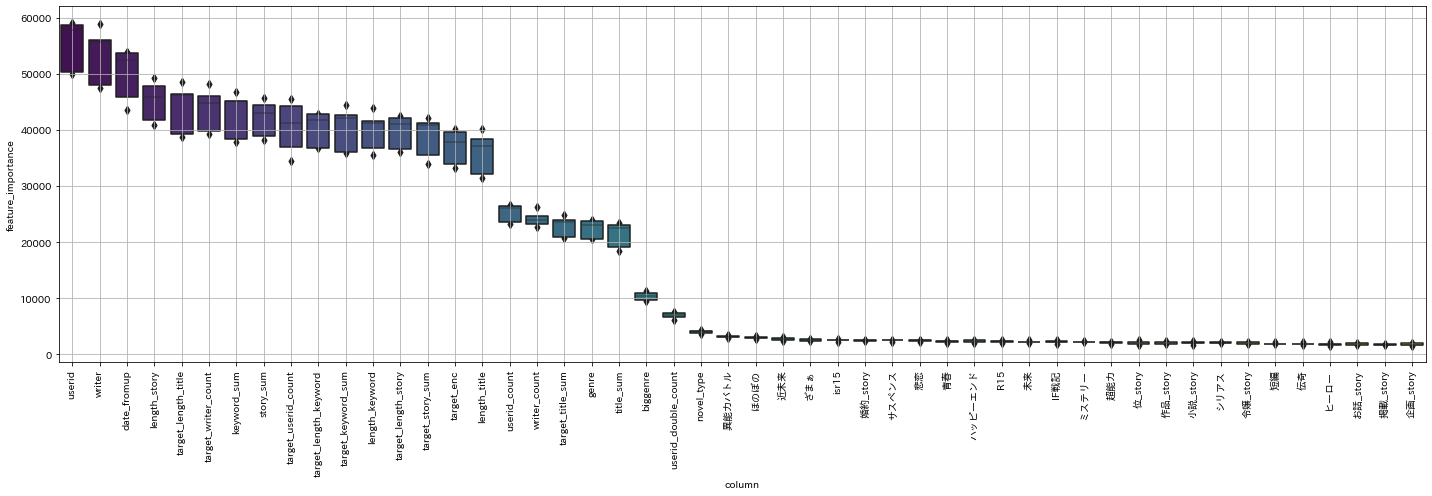

In [ ]:
fig, ax = visualize_importance(models_lgbm, x)

In [ ]:
y_pred_lgbm = np.array([model.predict(preprocessed_test_df.values) for model in models_lgbm])
y_pred_lgbm = np.mean(y_pred_lgbm, axis=0)
# y_pred_lgbm = np.where(y_pred_lgbm < 0, 0, y_pred_lgbm)

In [ ]:
y_pred_lgbm

array([[7.85186668e-01, 1.68896769e-01, 3.77360977e-02, 7.81933223e-03,
        3.61133700e-04],
       [7.71578852e-01, 2.16039939e-01, 1.16546337e-02, 6.06108036e-04,
        1.20467578e-04],
       [2.25669351e-01, 5.73444565e-01, 1.61783039e-01, 3.75082534e-02,
        1.59479179e-03],
       ...,
       [7.24853042e-01, 2.43082755e-01, 3.02015992e-02, 1.70620943e-03,
        1.56394255e-04],
       [7.30856532e-01, 2.36760431e-01, 3.06695456e-02, 1.37994503e-03,
        3.33546315e-04],
       [6.77389559e-01, 2.92562717e-01, 2.80363591e-02, 1.74276970e-03,
        2.68595726e-04]])

In [ ]:
sample_submission_df.head()

,ncode,proba_0,proba_1,proba_2,proba_3,proba_4
0,N4541HD,0,0,0,0,0
1,N4397HD,0,0,0,0,0
2,N4544HD,0,0,0,0,0
3,N4545HD,0,0,0,0,0
4,N4546HD,0,0,0,0,0


In [ ]:
pred_df = pd.DataFrame(y_pred_lgbm, columns = ['proba_0', 'proba_1', 'proba_2', 'proba_3', 'proba_4'])
pred_df

,proba_0,proba_1,proba_2,proba_3,proba_4
0,0.785187,0.168897,0.037736,0.007819,0.000361
1,0.771579,0.216040,0.011655,0.000606,0.000120
2,0.225669,0.573445,0.161783,0.037508,0.001595
3,0.700494,0.286272,0.011394,0.001671,0.000169
4,0.831552,0.158028,0.009925,0.000389,0.000107
...,...,...,...,...,...
8517,0.537521,0.448363,0.013655,0.000322,0.000138
8518,0.652268,0.328755,0.016901,0.001652,0.000423
8519,0.724853,0.243083,0.030202,0.001706,0.000156
8520,0.730857,0.236760,0.030670,0.001380,0.000334


In [ ]:
sample_submission_df['proba_0'] = pred_df['proba_0']
sample_submission_df['proba_1'] = pred_df['proba_1']
sample_submission_df['proba_2'] = pred_df['proba_2']
sample_submission_df['proba_3'] = pred_df['proba_3']
sample_submission_df['proba_4'] = pred_df['proba_4']

sample_submission_df.head()

,ncode,proba_0,proba_1,proba_2,proba_3,proba_4
0,N4541HD,0.785187,0.168897,0.037736,0.007819,0.000361
1,N4397HD,0.771579,0.216040,0.011655,0.000606,0.000120
2,N4544HD,0.225669,0.573445,0.161783,0.037508,0.001595
3,N4545HD,0.700494,0.286272,0.011394,0.001671,0.000169
4,N4546HD,0.831552,0.158028,0.009925,0.000389,0.000107


In [ ]:
sample_submission_df.tail()

,ncode,proba_0,proba_1,proba_2,proba_3,proba_4
8517,N5983HF,0.537521,0.448363,0.013655,0.000322,0.000138
8518,N5990HF,0.652268,0.328755,0.016901,0.001652,0.000423
8519,N5993HF,0.724853,0.243083,0.030202,0.001706,0.000156
8520,N5996HF,0.730857,0.236760,0.030670,0.001380,0.000334
8521,N5997HF,0.677390,0.292563,0.028036,0.001743,0.000269


In [ ]:
sample_submission_df.to_csv(output_path + save_nm, index = False)

In [ ]:
y_confirm_lgbm = np.array([model.predict(x.values) for model in models_lgbm])
y_confirm_lgbm = np.mean(y_confirm_lgbm, axis=0)

In [ ]:
confirm_df = pd.DataFrame(y_confirm_lgbm, columns = ['proba_0', 'proba_1', 'proba_2', 'proba_3', 'proba_4'])
confirm_df = pd.concat([preprocessed_train_df, confirm_df], axis = 1)
confirm_df.head(3)

In [ ]:
ext_cols = list(set(confirm_df.columns) & set(train_df.columns))

In [ ]:
ext_cols += ['proba_0', 'proba_1', 'proba_2', 'proba_3', 'proba_4', 'date_fromup', 'length_title', 'length_story', 'length_keyword', 'userid_count', 'keyword_sum']

In [ ]:
ext_cols

In [ ]:
confirm_df2 = confirm_df.copy()[ext_cols]

In [ ]:
eval0 = confirm_df2[confirm_df2['fav_novel_cnt_bin'] == 0]

In [ ]:
for ii in [0, 1, 2, 3, 4]:
    print(ii)
    
    tmp_df = confirm_df2[confirm_df2['fav_novel_cnt_bin'] == ii]


    if ii == 0:
        sns.boxplot(x = 'fav_novel_cnt_bin', y = 'proba_0', data = tmp_df)
        plt.ylim(0, 1)
        plt.show()

        
    elif ii == 1:
        sns.boxplot(x = 'fav_novel_cnt_bin', y = 'proba_1', data = tmp_df)
        plt.ylim(0, 1)
        plt.show()

        
    elif ii == 2:
        sns.boxplot(x = 'fav_novel_cnt_bin', y = 'proba_2', data = tmp_df)
        plt.ylim(0, 1)
        plt.show()

        
    elif ii == 3:
        sns.boxplot(x = 'fav_novel_cnt_bin', y = 'proba_3', data = tmp_df)
        plt.ylim(0, 1)
        plt.show()


    elif ii == 4:
        sns.boxplot(x = 'fav_novel_cnt_bin', y = 'proba_4', data = tmp_df)
        plt.ylim(0, 1)
        plt.show()


    print('*'*100)
    print('*'*100)
    print('*'*100)
    print('*'*100)

In [ ]:
# preprocessed_train_df.to_csv(interm_path + 'grid_search_train_df.csv', index = False)

In [ ]:
# https://datumstudio.jp/blog/python%E3%81%AB%E3%82%88%E3%82%8B%E6%97%A5%E6%9C%AC%E8%AA%9E%E5%89%8D%E5%87%A6%E7%90%86%E5%82%99%E5%BF%98%E9%8C%B2/